# 6: Selection of best phrase grounding

Each image has four phrase grounding results: two from the caption and two from the title, as it has been run on GLIP and MDETR. The best phrase grounding results are selected using a user-friendly GUI. 

In [1]:
import copy
import pickle
import sys
from itertools import compress
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from matplotlib.patches import Polygon
from skimage.measure import find_contours
from torchvision.ops import nms

import src.GLIP.maskrcnn_benchmark as maskrcnn_benchmark

sys.modules['maskrcnn_benchmark'] = maskrcnn_benchmark

In [2]:
phrase_grounding_results_folder = '../data/phrase_grounding_results/'
dataset_for_phrase_grounding = '../data/dataset_for_phrase_grounding/'
save_dir = '../data/phrase_grounding_selected/'
MDETR_caption = pickle.load(open(phrase_grounding_results_folder + 'MDETR_full_caption.p', 'rb'))
MDETR_title = pickle.load(open(phrase_grounding_results_folder + 'MDETR_full_title.p', 'rb'))
GLIP_caption = pickle.load(open(phrase_grounding_results_folder + 'GLIP_full_caption.p', 'rb'))
GLIP_title = pickle.load(open(phrase_grounding_results_folder + 'GLIP_full_title.p', 'rb'))
dataset = pickle.load(open(dataset_for_phrase_grounding + 'dataset.p', 'rb'))

In [3]:
def GLIP2MDETR(glip_array):
    """
    Transforms a GLIP array into a MDETR-format array
    :param glip_array: array of inference of GLIP
    :return: the array in a MDETR-format
    """
    mdetr_array = []
    for elem in glip_array:
        caption = [elem[1][k - 1] if k < len(elem[1]) else elem[1][len(elem[1]) - 1] for k in
                   elem[0].get_field('labels')]
        mdetr_array.append([elem[0].get_field('scores'), elem[0].bbox, caption])
    return mdetr_array


GLIP_caption = GLIP2MDETR(GLIP_caption)
GLIP_title = GLIP2MDETR(GLIP_title)

A few helper functions

In [4]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]


def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image


def get_color(label, set_label):
    for i, elem in enumerate(set_label):
        if elem == label:
            return i
    return 0


def plot_results(ax, pil_img, results, masks=None, conf=0.7):
    np_image = np.array(pil_img)
    colors = COLORS * 100
    keep = results[0] > conf
    scores = results[0][keep]
    boxes = results[1][keep]
    labels = list(compress(results[2], keep))
    set_label = set(labels)

    if masks is None:
        masks = [None for _ in range(len(scores))]
    else:
        masks = masks[results[0] > conf]

    for s, (xmin, ymin, xmax, ymax), l, mask in zip(scores, boxes.tolist(), labels, masks):
        c = colors[get_color(l, set_label)]
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=1))
        text = f'{l}: {s:0.2f}'
        ax.text(int(xmin), int(ymin), text, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

        if mask is None:
            continue
        np_image = apply_mask(np_image, mask, c)

        padded_mask = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=c)
            ax.add_patch(p)

    ax.imshow(np_image)

    return ax


def labelwise_nms(segmentation_array):
    segmentation_array_ = []
    for i, elem in enumerate(segmentation_array):
        segmentation_array_.append(list(elem))
    seg_filtered = copy.deepcopy(segmentation_array_)
    for index_, elem in enumerate(segmentation_array_):
        unique_caption = set(elem[2])
        if len(elem[2]) != 0:
            boolean_index = [[elem_ == cap for elem_ in elem[2]] for cap in list(unique_caption)]
            idx = [[i for i, x in enumerate(bool_idx) if x] for bool_idx in boolean_index]
            idx_to_keep = [nms(boxes=torch.index_select(elem[1], 0, torch.tensor(idx_)),
                               scores=torch.index_select(elem[0], 0, torch.tensor(idx_)), iou_threshold=0.2) for idx_ in
                           idx]
            scores = []
            boxes = []
            captions = []
            for idx_, idx_tokeep, caption in zip(idx, idx_to_keep, list(unique_caption)):
                scores += (elem[0][idx_][idx_tokeep])
                boxes += (elem[1][idx_][idx_tokeep])
                captions += (
                    [elem[2][i].removeprefix(' ') for i in torch.index_select(torch.tensor(idx_), 0, idx_tokeep)])

            seg_filtered[index_][0] = torch.stack(scores, dim=0)
            seg_filtered[index_][1] = torch.stack(boxes, dim=0)
            seg_filtered[index_][2] = captions

    return seg_filtered


def global_nms(segmentation_array):
    segmentation_array_ = []
    for i, elem in enumerate(segmentation_array):
        segmentation_array_.append(list(elem))
    seg_filtered = copy.deepcopy(segmentation_array_)
    for index_, elem in enumerate(segmentation_array_):
        if len(elem[2]) != 0:
            idx_to_keep = nms(boxes=elem[1], scores=elem[0], iou_threshold=0.9)
            scores = []
            boxes = []
            captions = []
            scores += (elem[0][idx_to_keep])
            boxes += (elem[1][idx_to_keep])
            captions += ([elem[2][i].removeprefix(' ') for i in idx_to_keep])

            seg_filtered[index_][0] = torch.stack(scores, dim=0)
            seg_filtered[index_][1] = torch.stack(boxes, dim=0)
            seg_filtered[index_][2] = captions

    return seg_filtered

Non-max suppression local then global

In [5]:
MDETR_caption = global_nms(labelwise_nms(MDETR_caption))
MDETR_title = global_nms(labelwise_nms(MDETR_title))
GLIP_caption = global_nms(labelwise_nms(GLIP_caption))
GLIP_title = global_nms(labelwise_nms(GLIP_title))

In [6]:
matplotlib.rcParams['interactive'] == True

False

## Selection of the best phrase grounding inference

In [8]:
%matplotlib qt
i = 0

def save_result(i, model, expr):
    caption = dataset[i][expr]['raw']
    if model == 'GLIP':
        if expr == 'caption':
            results = GLIP_caption[i]
        else:
            results = GLIP_title[i]
    else:
        if expr == 'caption':
            results = MDETR_caption[i]
        else:
            results = MDETR_title[i]

    pickle.dump({
        'idx': i,
        'filename': dataset[i]['filename'],
        'caption': caption,
        'results': results,
        'model': model,
        'expr': expr
    }, open(save_dir + f'{dataset[i]["filename"].removesuffix(".jpg")}.p', 'wb'))


def on_press(event):
    print('press', event.key)
    sys.stdout.flush()
    global i
    # QUIT
    if event.key == 'x':
        plt.close('all')
        with open('temp/latest.txt', 'w') as f:
            f.write(i)
        print(i)
    # MDETR CAPTION
    elif event.key == 'q':
        plt.close('all')
        save_result(i, 'MDETR', 'caption')
        i += 1
        load_slide()
    # GLIP CAPTION
    elif event.key == 'e':
        plt.close('all')
        save_result(i, 'GLIP', 'caption')
        i += 1
        load_slide()
    # MDETR TITLE
    elif event.key == 'a':
        plt.close('all')
        save_result(i, 'MDETR', 'title')
        i += 1
        load_slide()
    # GLIP TITLE
    elif event.key == 'd':
        plt.close('all')
        save_result(i, 'GLIP', 'title')
        i += 1
        load_slide()
    # PASS
    elif event.key == 'p':
        plt.close('all')
        with open('temp/none.txt', 'a') as file:
            file.write(str(i) + ' ')
        i += 1
        load_slide()
    elif event.key == 'r':
        i -= 1
        load_slide()


def load_slide():
    global i
    elem = dataset[i]
    fig, ax = plt.subplots(2, 2, figsize=(35, 20))

    fig.canvas.mpl_connect('key_press_event', on_press)
    fig.suptitle(f'{elem["caption"]["raw"]}\n{elem["title"]["raw"]}', fontsize=15)
    im = Image.open(dataset_for_phrase_grounding + 'img/' + elem["filename"]).convert('RGB')

    ax[0, 0] = plot_results(ax=ax[0, 0], pil_img=im, results=MDETR_caption[i])
    ax[0, 0].title.set_text(f'MDETR {elem["caption"]["raw"]}')

    ax[1, 0] = plot_results(ax[1, 0], im, MDETR_title[i])
    ax[1, 0].title.set_text(f'MDETR {elem["title"]["raw"]}')

    ax[0, 1] = plot_results(ax[0, 1], im, GLIP_caption[i], conf=0)
    ax[0, 1].title.set_text(f'GLIP {elem["caption"]["raw"]}')

    ax[1, 1] = plot_results(ax[1, 1], im, GLIP_title[i], conf=0)
    ax[1, 1].title.set_text(f'GLIP {elem["title"]["raw"]}')

    for ax_ in ax:
        for ax__ in ax_:
            ax__.axis('off')
    # plt.savefig(f'./figs_mdetr_glip/{i}.png')
    # plt.close()
    plt.show()


load_slide()

## Best results visualization

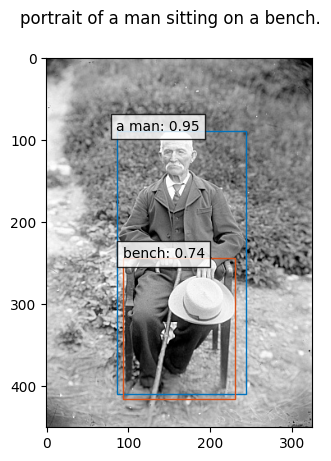

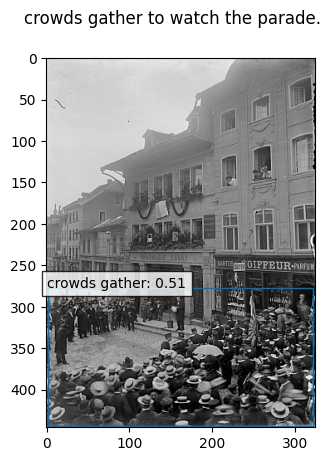

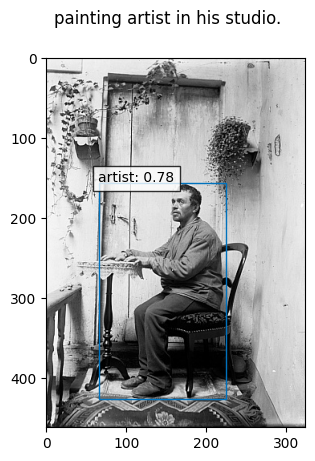

In [17]:
%matplotlib inline
# iterate over files in that directory
files = Path(save_dir).glob('*.p')

for file in files:
    result = pickle.load(open(file, 'rb'))
    fig, ax = plt.subplots()
    im = Image.open(dataset_for_phrase_grounding + 'img/' + result["filename"]).convert('RGB')
    if result["model"] == "GLIP":
        conf = 0
    else:
        conf = 0.7
    ax = plot_results(ax=ax, pil_img=im, results=result["results"], conf=conf)
    fig.suptitle(result['caption'])
    plt.savefig(save_dir + result["filename"])